# Photometry Walkthrough

Goal: Perform stellar photometry of the stars in the Carina images.

This is based _loosely_ on the jdat notebook `psf_photometry/NIRCam_PSF_Photometry_Example.ipynb#`

In [4]:
import photutils

In [5]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry

In [6]:
import numpy as np
from astropy.stats import mad_std
from astropy import stats

In [11]:
from astropy.io import fits
from astropy import wcs
from astropy.table import Table

In [12]:
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

In [13]:
im1 = fits.open('/orange/adamginsburg/jwst/jw02731/L3/t/jw02731-o001_t017_nircam_clear-f444w_i2d.fits')
data = im1[1].data

In [14]:
basetable = Table.read('/orange/adamginsburg/jwst/jw02731/L3/t/jw02731-o001_t017_nircam_clear-f444w_cat.ecsv')

##  Establish some Regions of Interest (ROIs)

these are just to zoom in on the images so we can see the stars

In [15]:
import regions
rois = regions.Regions.read('/orange/adamginsburg/jwst/jw02731/ROIs.reg')
r0, r1 = rois

## Get filter information 

from the Spanish Virtual Observatory Filter Profile Service

In [16]:
from astroquery.svo_fps import SvoFps

In [17]:
instrument = im1[0].header['INSTRUME']
telescope = im1[0].header['TELESCOP']
filt = im1[0].header['FILTER']
wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')

In [18]:
from astropy import units as u

In [19]:
filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
filter_table.add_index('filterID')
instrument = 'NIRCam'
eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filt}']['WavelengthEff'] * u.AA

## Calculate the FWHM for DAOStarFinder

In [20]:
fwhm = (1.22 * eff_wavelength / (6.5*u.m)).to(u.arcsec, u.dimensionless_angles())
fwhm

<Quantity 0.16842379 arcsec>

In [21]:
ww = wcs.WCS(im1[1].header)
pixscale = ww.proj_plane_pixel_area()**0.5
fwhm_pix = (fwhm / pixscale).decompose().value
fwhm_pix

Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574327 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654444171.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.677224740298114

## Identify bright stars to create an effective point spread function (ePSF)

In [22]:
data = im1[1].data
mad_std = stats.mad_std(data)
med = np.nanpercentile(data, 15)
daofind = DAOStarFinder(threshold=15 * mad_std + med, fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                        sharplo=0.30, sharphi=1.40)

psf_stars = daofind(data)

In [23]:
len(psf_stars)

4124

In [24]:
daofind_tot = DAOStarFinder(threshold=8 * mad_std + med, fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)

stars_tot = daofind_tot(data)
len(stars_tot)

6116

In [25]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
import webbpsf

In [26]:
# This is a nice idea, but doesn't work b/c we're working on L3 data

#nrc = webbpsf.NIRCam()
#
#nrc.detector = instrument 
#nrc.filter = filt
#
#src = webbpsf.specFromSpectralType('G5V', catalog='phoenix')
#
#gridpsf = nrc.psf_grid(num_psfs=25, oversample=4, source=src, all_detectors=False, fov_pixels=11,
#                         save=True, use_detsampled_psf=True)

from astropy.visualization import simple_norm

norm_epsf = simple_norm(gridpsf.data[0], 'log', percent=99.)
ax.set_title(filt, fontsize=40)
ax.imshow(gridpsf.data[0], norm=norm_epsf)
ax.set_xlabel('X [px]', fontsize=30)
ax.set_ylabel('Y [px]', fontsize=30)

In [27]:
from astropy.table import Table
from astropy.nddata import NDData

# Try to build effective PSFs

There are a few attempts here, none entirely satisfactory.  Quadratic is better though.

In [146]:
data_cts = data / im1[1].header['PHOTMJSR']

stars_tbl = Table()
stars_tbl['x'] = psf_stars['xcentroid']
stars_tbl['y'] = psf_stars['ycentroid']

data_bkgsub = data.copy()

data_bkgsub -= med

nddata = NDData(data=data_bkgsub)
stars = extract_stars(nddata, stars_tbl, size=11)


epsf_builder = EPSFBuilder(oversampling=4, maxiters=10, progress_bar=True)

epsf, fitted_stars = epsf_builder(stars)

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

In [129]:
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
from astropy.visualization import simple_norm

In [116]:
assert pl.rcParams['figure.facecolor'] == 'w'

Text(0, 0.5, 'Y [px]')

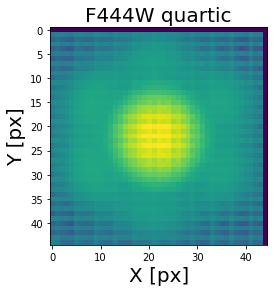

In [117]:
ax = pl.gca()
norm_epsf = simple_norm(epsf.data, 'log', percent=99.)
ax.set_title(f"{filt} quartic", fontsize=20)
ax.imshow(epsf.data, norm=norm_epsf)
ax.set_xlabel('X [px]', fontsize=20)
ax.set_ylabel('Y [px]', fontsize=20)

In [ ]:
data_cts = data / im1[1].header['PHOTMJSR']

stars_tbl = Table()
stars_tbl['x'] = psf_stars['xcentroid']
stars_tbl['y'] = psf_stars['ycentroid']

data_bkgsub = data.copy()

data_bkgsub -= med

nddata = NDData(data=data_bkgsub)
stars = extract_stars(nddata, stars_tbl, size=31)


epsf_builder = EPSFBuilder(oversampling=4, maxiters=10, progress_bar=True, smoothing_kernel='quadratic')

epsf_quadratic, fitted_stars = epsf_builder(stars)
del nddata, data_bkgsub

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
ax = pl.gca()
norm_epsf = simple_norm(epsf_quadratic.data, 'log', percent=99.)
ax.set_title(f"{filt} quadratic", fontsize=20)
im = ax.imshow(epsf_quadratic.data, norm=norm_epsf)
pl.colorbar(mappable=im)
ax.set_xlabel('X [px]', fontsize=20)
ax.set_ylabel('Y [px]', fontsize=20)

In [33]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

## Iterative PSF photometry

This is the 'final step', and wasn't good enough this time.  So I pushed it to the end.

In [34]:
if False:
    # takes a long time
    mmm_bkg = MMMBackground()
    daogroup = DAOGroup(10.0 * fwhm_pix)
    phot = IterativelySubtractedPSFPhotometry(finder=daofind_tot, group_maker=daogroup,
                                              bkg_estimator=mmm_bkg, psf_model=epsf_quadratic,
                                              fitter=LevMarLSQFitter(),
                                              niters=2, fitshape=(11, 11), aperture_radius=2*fwhm_pix)
    result = phot(data)
    resid = phot.get_residual_image()

In [35]:
if False:
    mask = (r0|r1).to_pixel(ww).to_mask()
    mdata = mask.cutout(resid)
    bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)

    pl.figure(figsize=(12,18))
    ax = pl.subplot(projection=ww[bigslc])
    ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
    r0.to_pixel(ww[bigslc]).plot(ax=ax)
    r1.to_pixel(ww[bigslc]).plot(ax=ax)
    del resid

# Background Estimation

We now go through a many-step process of estimating the starless background

In [36]:
from scipy.ndimage import median_filter

In [47]:
os.chdir('/orange/adamginsburg/jwst/jw02731/background_estimation/')

In [49]:
if os.path.exists('F444W_median_filter_15pix.fits'):
    medfilt = fits.getdata('F444W_median_filter_15pix.fits')
else:
    medfilt = median_filter(data, size=[15,15])
    fits.PrimaryHDU(data=medfilt, header=im1[1].header).writeto('F444W_median_filter_15pix.fits', overwrite=True)

In [120]:
med51name = 'F444W_median_filter_51pix.fits'
if os.path.exists(med51name):
    medfilt = fits.getdata(med51name)
else:
    medfilt = median_filter(data, size=[51,51])
    fits.PrimaryHDU(data=medfilt, header=im1[1].header).writeto(med51name, overwrite=True)

<WCSAxesSubplot:>

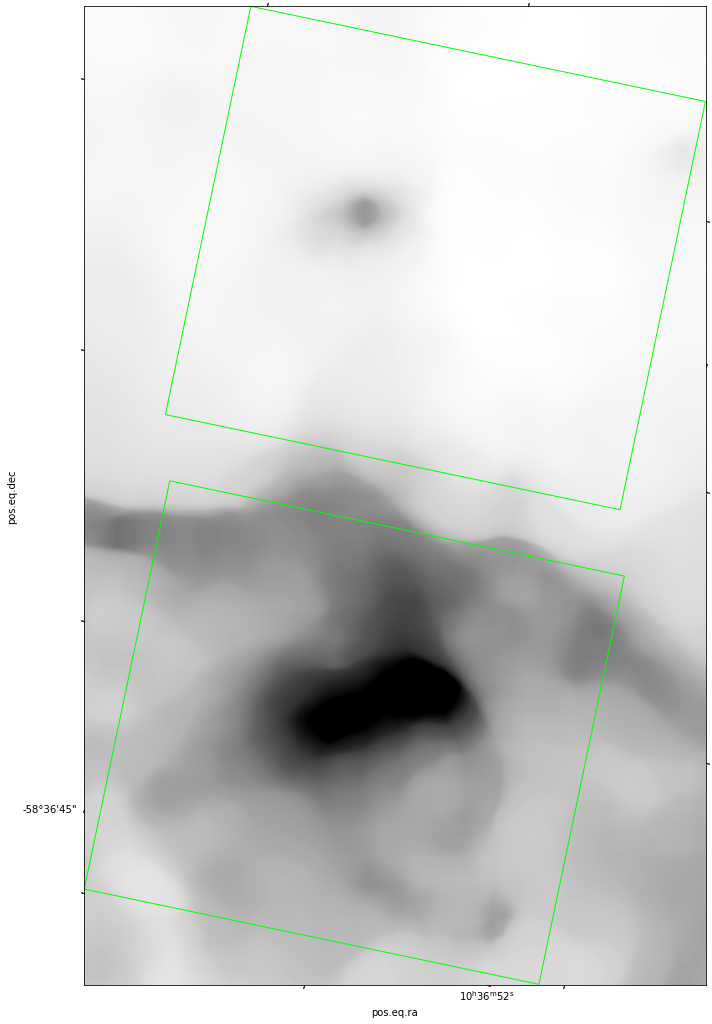

In [121]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(medfilt)
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

<WCSAxesSubplot:>

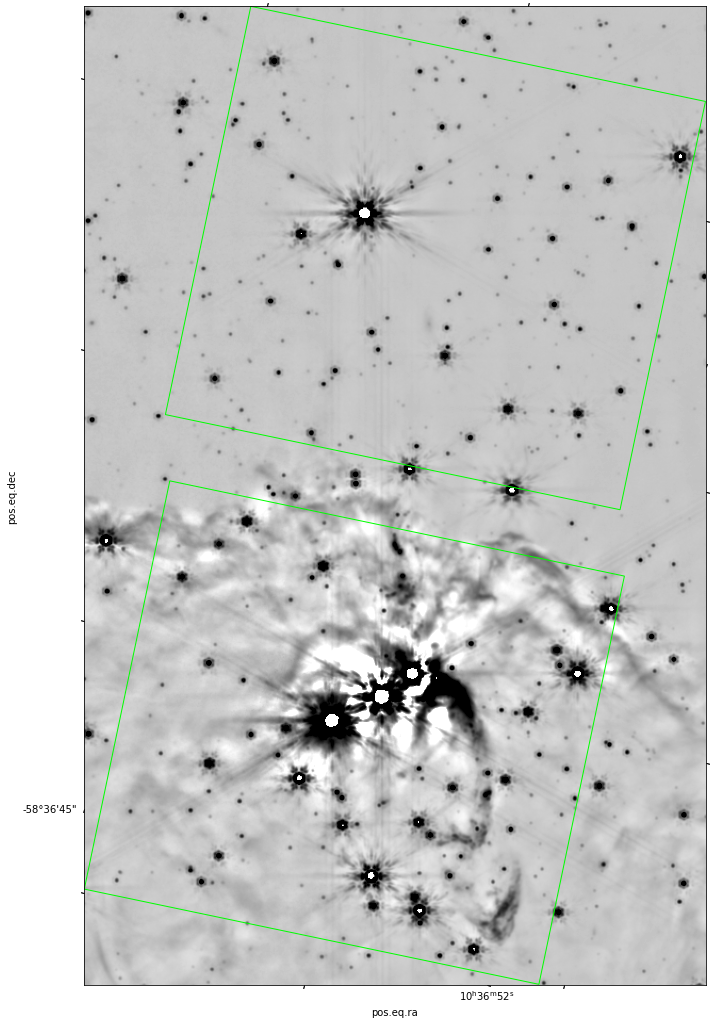

In [122]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(data)-mask.cutout(medfilt)
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

# Experiment: Does segmentation source ID work?

In short, no: it includes way too many non-stars

In [123]:
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

sigma_clip = SigmaClip(sigma=3.0, maxiters=10)

medfilt_sub = data - medfilt

threshold = detect_threshold(medfilt_sub, nsigma=5.0, sigma_clip=sigma_clip)
segment_img = detect_sources(medfilt_sub, threshold, npixels=10)
footprint = circular_footprint(radius=2)
segment_mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(medfilt_sub, sigma=3.0, mask=segment_mask)
print((mean, median, std))  

(-0.009894832037389278, -0.008663415908813477, 0.09617935121059418)


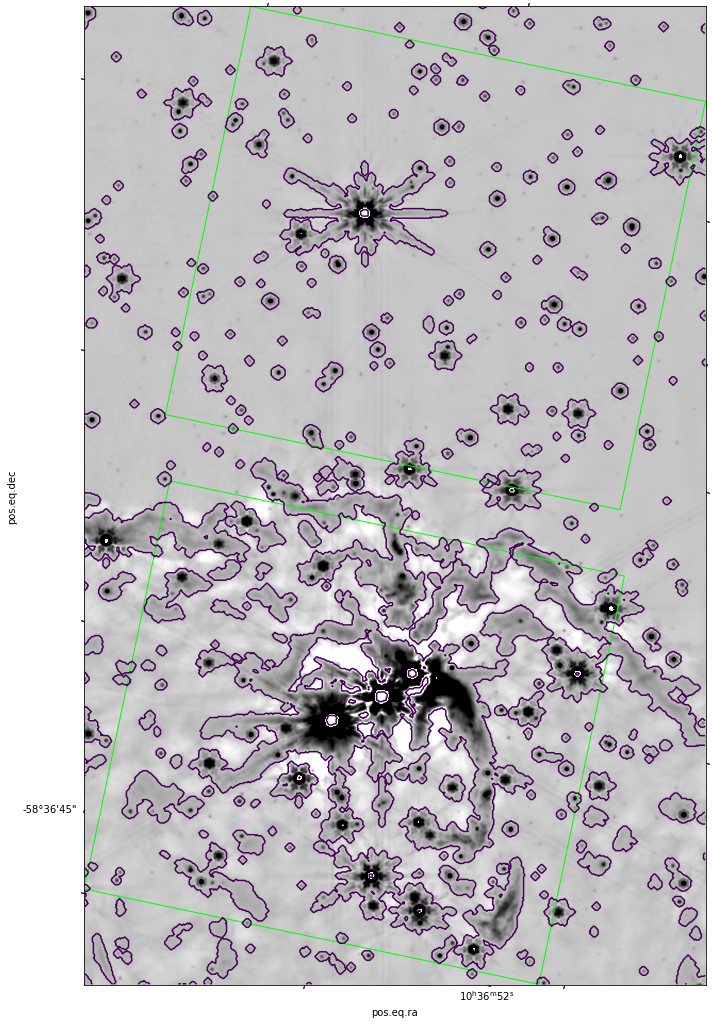

In [124]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(data)-mask.cutout(medfilt)
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)
ax.contour((segment_mask[bigslc]), levels=[0.5])

# Try ESPF building again from the background-subtracted data

And then compare to the webbpsf model

In [ ]:
data_cts = medfilt_sub / im1[1].header['PHOTMJSR']

stars_tbl = Table()
stars_tbl['x'] = psf_stars['xcentroid']
stars_tbl['y'] = psf_stars['ycentroid']

nddata = NDData(data=data_cts)
stars = extract_stars(nddata, stars_tbl, size=31)

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10, progress_bar=True, smoothing_kernel='quadratic')

epsf_quadratic_medfilt, fitted_stars = epsf_builder(stars)
fits.PrimaryHDU(data=epsf_quadratic_medfilt.data).write('F444W_ePSF_quadratic_medianbackgroundsubtracted.fits')
del nddata

In [105]:
import webbpsf
nc = webbpsf.NIRCam()
nc.filter =  'F444W'
oversample = 4
psf = nc.calc_psf(oversample=oversample, fov_pixels=31)     # returns an astropy.io.fits.HDUlist containing PSF and header

In [44]:
nrc = webbpsf.NIRCam()
nrc.filter =  'F444W'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


Running instrument: NIRCam, filter: F444W
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (682, 682) pixels
    Position 7/16: (682, 1365) pixels
    Position 8/16: (682, 2047) pixels
    Position 9/16: (1365, 0) pixels
    Position 10/16: (1365, 682) pixels
    Position 11/16: (1365, 1365) pixels
    Position 12/16: (1365, 2047) pixels
    Position 13/16: (2047, 0) pixels
    Position 14/16: (2047, 682) pixels
    Position 15/16: (2047, 1365) pixels
    Position 16/16: (2047, 2047) pixels


In [150]:
fitter = LevMarLSQFitter()

In [161]:
yy,xx = np.indices(epsf_quadratic_medfilt.data.shape)
xc,yc = np.unravel_index(epsf_quadratic_medfilt.data.argmax(), epsf_quadratic_medfilt.data.shape)
grid.x_0 = xc/oversample
grid.y_0 = yc/oversample
grid.flux = 1
fitted_gridmod = fitter(model=grid, x=xx/oversample, y=yy/oversample, z=epsf_quadratic_medfilt.data,)
gridmodpsf = (fitted_gridmod(xx/oversample, yy/oversample))
fitted_gridmod

<GriddedPSFModel(flux=1.06440988, x_0=15.45434715, y_0=15.54810264)>

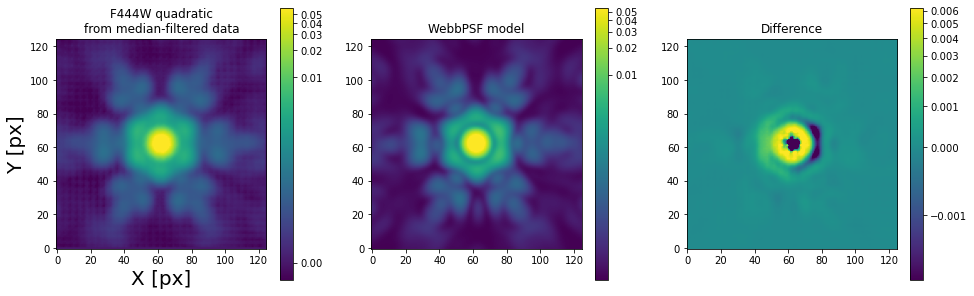

In [162]:
pl.figure(figsize=(16,5))
ax = pl.subplot(1,3,1)
norm_epsf = simple_norm(epsf_quadratic_medfilt.data, 'log', percent=99.)
ax.set_title(f"{filt} quadratic\nfrom median-filtered data")
im = ax.imshow(epsf_quadratic_medfilt.data, norm=norm_epsf)
pl.colorbar(mappable=im)
ax.set_xlabel('X [px]', fontsize=20)
ax.set_ylabel('Y [px]', fontsize=20)
ax2 = pl.subplot(1,3,2)
ax2.set_title("WebbPSF model")
dd = gridmodpsf    
norm = simple_norm(dd, 'log', percent=99.)
im2 = ax2.imshow(dd, norm=norm)       
pl.colorbar(mappable=im2)
ax3 = pl.subplot(1,3,3)
ax3.set_title("Difference")
#dd = (epsf_quadratic_medfilt.data/epsf_quadratic_medfilt.data.max()) - gridmodpsf/gridmodpsf.max()
dd = (epsf_quadratic_medfilt.data) - gridmodpsf
norm = simple_norm(dd, 'asinh', percent=99)
im3 = ax3.imshow(dd, norm=norm)
pl.colorbar(mappable=im3)

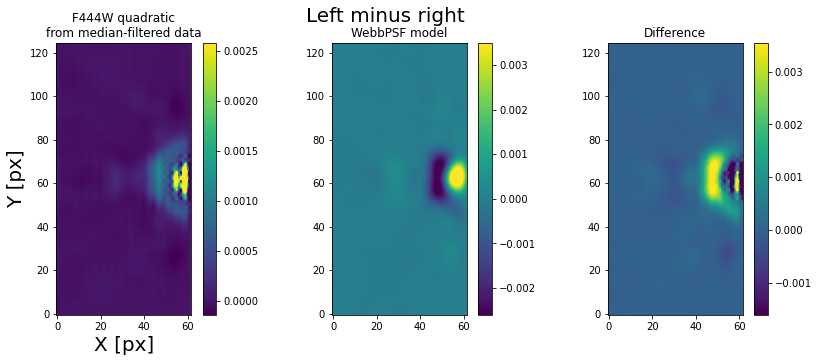

In [163]:
pl.figure(figsize=(14,5))
pl.suptitle("Left minus right", fontsize=20)
ax = pl.subplot(1,3,1)
dd = epsf_quadratic_medfilt.data
dd = dd[:,:dd.shape[1]//2] - dd[:,:dd.shape[1]//2:-1]
norm_epsf = simple_norm(dd, 'linear', percent=99.)
ax.set_title(f"{filt} quadratic\nfrom median-filtered data")
im = ax.imshow(dd, norm=norm_epsf)
pl.colorbar(mappable=im)
ax.set_xlabel('X [px]', fontsize=20)
ax.set_ylabel('Y [px]', fontsize=20)
ax2 = pl.subplot(1,3,2)
ax2.set_title("WebbPSF model")
dd = gridmodpsf    
dd = dd[:,:dd.shape[1]//2] - dd[:,:dd.shape[1]//2:-1]

norm = simple_norm(dd, 'linear', percent=99.)
im2 = ax2.imshow(dd, norm=norm)       
pl.colorbar(mappable=im2)
ax3 = pl.subplot(1,3,3)
ax3.set_title("Difference")
#dd = (epsf_quadratic_medfilt.data/epsf_quadratic_medfilt.data.max()) - gridmodpsf/gridmodpsf.max()
dd = (epsf_quadratic_medfilt.data) - gridmodpsf
dd = dd[:,:dd.shape[1]//2] - dd[:,:dd.shape[1]//2:-1]

norm = simple_norm(dd, 'linear', percent=99)
im3 = ax3.imshow(dd, norm=norm)
pl.colorbar(mappable=im3)

The empirical model is pretty good but less sharp than the JW version.

There is asymmetry in both models.  

In [164]:
sz = 31
yinds, xinds = np.indices([sz, sz])
epsf_quadratic_kernel = epsf_quadratic_medfilt.evaluate(xinds, yinds, 1, (sz-1/2), (sz-1/2))

# Replace bad pixels

 1) Replace the zeros with NaNs (bad pixels are set to zero)
 2) Convolve with the WebbPSF to fill in the NaNs
 3) record which pixels were interpolated into (we'll use this later)
 4) set NaNs back to zero because of the edges

In [183]:
outname = 'F444W_median-filter-subtracted.fits'
if os.path.exists(outname):
   
    medfiltsub = fits.getdata(outname)
else:
    medfiltsub = data-medfilt
    medfiltsub[data==0] = np.nan
    fits.PrimaryHDU(data=medfiltsub, header=im1[1].header).writeto(outname, overwrite=True)
    
outname = 'F444W_saturated-pixels-replaced-smoothed-with-PSF.fits'
if os.path.exists(outname):
    datafilt_conv_psf = fits.getdata(outname)
else:
    yy,xx = np.indices([31,31])
    gridmod_psf_nooversample = fitted_gridmod(xx,yy)
    datafilt_conv_psf = (convolve(medfiltsub, gridmod_psf_nooversample, nan_treatment='interpolate'))
    datafilt_conv_psf = np.nan_to_num(datafilt_conv_psf)
    fits.PrimaryHDU(data=datafilt_conv_psf, header=im1[1].header).writeto(outname, overwrite=True)
    
filled_in_pixels = (data==0) & ~np.isnan(medfiltsub)

<WCSAxesSubplot:>

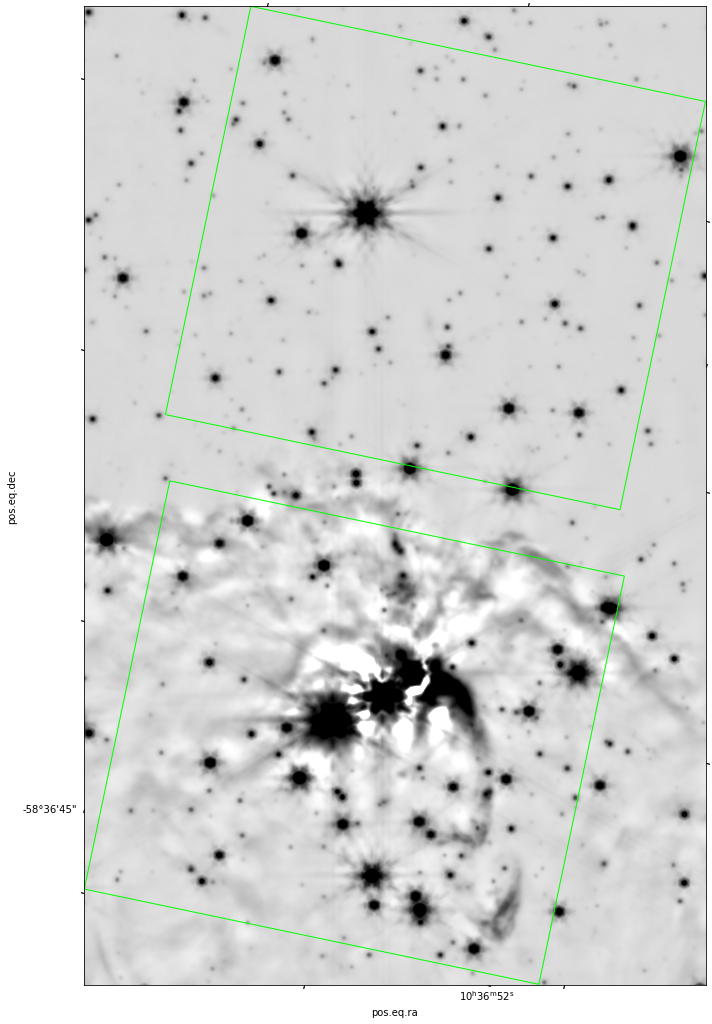

In [192]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(datafilt_conv_psf)
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

# Source finding on a few different data sets

We first have 'medfilt_sub', which is just the data minus the median-filtered data.

`datafilt_conv_psf` is the same image, but with saturated pixels replaced by interpolated values

In [193]:
err_est = stats.mad_std(medfilt_sub)
daofind_deep = DAOStarFinder(threshold=10 * err_est, fwhm=fwhm_pix, roundhi=0.25, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)

stars_deep = daofind_deep(data-medfilt)
len(stars_deep)

20660

In [194]:
err_est_conv = stats.mad_std(datafilt_conv_psf)
print(err_est_conv)
daofind_deep = DAOStarFinder(threshold=10 * err_est_conv, fwhm=fwhm_pix*2**0.5, roundhi=0.25, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)

stars_deep_conv = daofind_deep(datafilt_conv_psf)
len(stars_deep_conv)

0.08851090107744486


16461

In [195]:
daofind_shallow = DAOStarFinder(threshold=250 * err_est, fwhm=fwhm_pix, roundhi=3, roundlo=-1.0,
                            sharplo=0.10, sharphi=2.40)

stars_shallow = daofind_shallow(data-medfilt)
len(stars_shallow)

4277

In [200]:
daofind_shallow_conv = DAOStarFinder(threshold=250 * err_est_conv, fwhm=fwhm_pix*np.sqrt(2), roundhi=4, roundlo=-1.0,
                            sharplo=0.001, sharphi=4.40)

stars_shallow_conv = daofind_shallow_conv(datafilt_conv_psf)
len(stars_shallow_conv)

2444

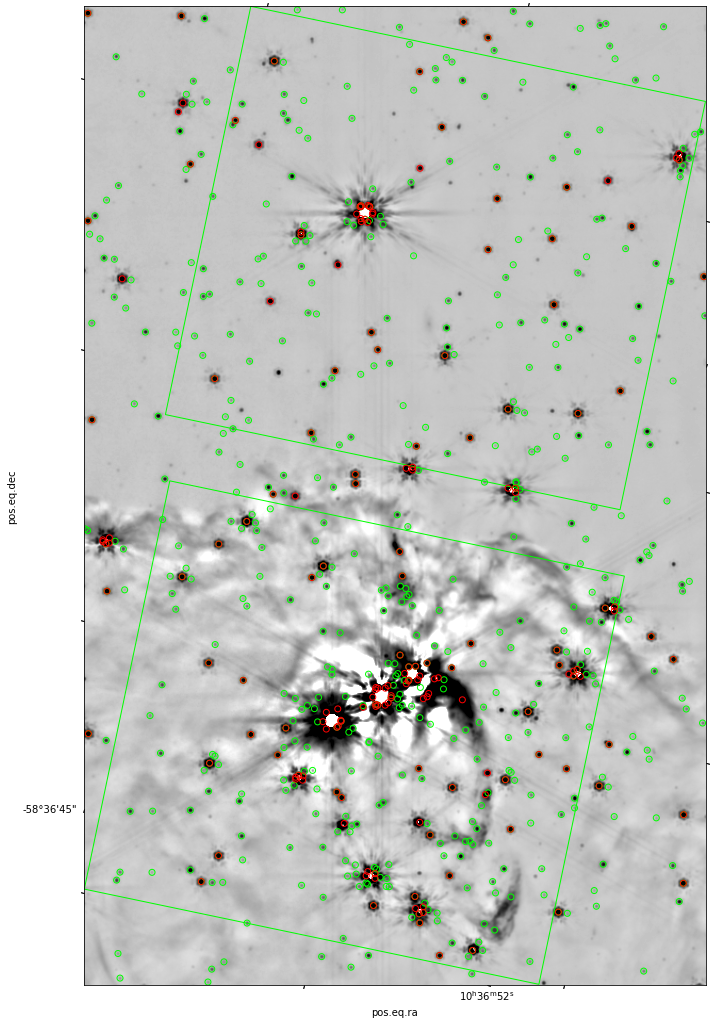

In [202]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(data)-mask.cutout(medfilt)
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)
xx, yy = stars_deep['xcentroid'], stars_deep['ycentroid']
sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
                for xi, yi in zip(xx,yy)])
ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', facecolor='none', edgecolor='lime')

xx, yy = stars_shallow['xcentroid'], stars_shallow['ycentroid']
sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
                for xi, yi in zip(xx,yy)])
ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', facecolor='none', edgecolor='red')

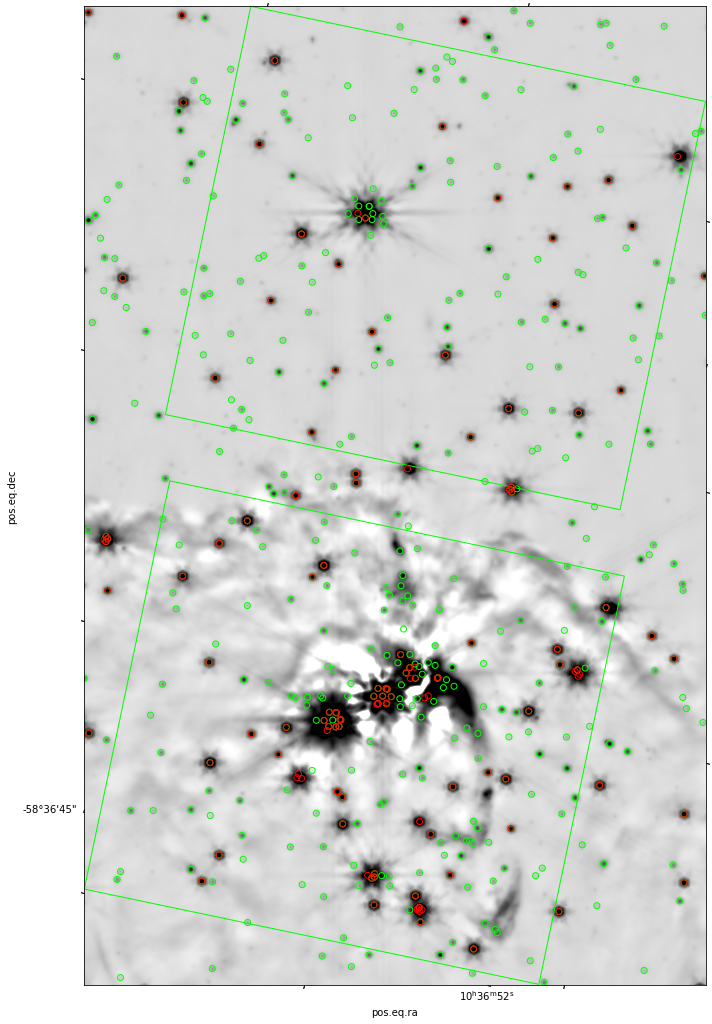

In [203]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(datafilt_conv_psf)
bigslc, smlslc = mask.bbox.get_overlap_slices(datafilt_conv_psf.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)
xx, yy = stars_deep_conv['xcentroid'], stars_deep_conv['ycentroid']
sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
                for xi, yi in zip(xx,yy)])
ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', facecolor='none', edgecolor='lime')

xx, yy = stars_shallow_conv['xcentroid'], stars_shallow_conv['ycentroid']
sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
                for xi, yi in zip(xx,yy)])
ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', facecolor='none', edgecolor='red')

# Try to filter out bad stars


https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html

DAOStarFinder calculates the object roundness using two methods. 

The roundlo and roundhi bounds are applied to both measures of roundness. 

The first method (roundness1; called SROUND in DAOFIND) is based on the source symmetry and is the ratio of a measure of the object’s bilateral (2-fold) to four-fold symmetry. 

The second roundness statistic (roundness2; called GROUND in DAOFIND) measures the ratio of the difference in the height of the best fitting Gaussian function in x minus the best fitting Gaussian function in y, divided by the average of the best fitting Gaussian functions in x and y. 

A circular source will have a zero roundness.

A source extended in x or y will have a negative or positive roundness, respectively.



## Exploration

We therefore plot our target field and overplot a few key parameters:

 * `roundness1`
 * `roundness2`
 * `sharpness`

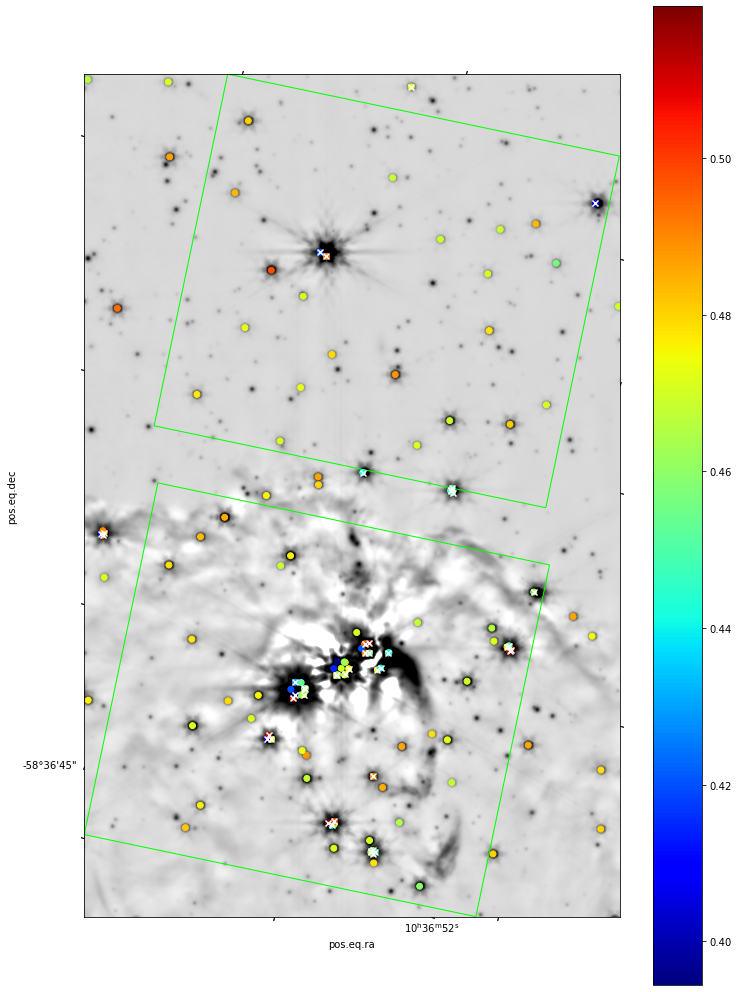

In [204]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(datafilt_conv_psf)
bigslc, smlslc = mask.bbox.get_overlap_slices(datafilt_conv_psf.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

xx, yy = stars_shallow_conv['xcentroid'], stars_shallow_conv['ycentroid']
sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
                for xi, yi in zip(xx,yy)])
mappable = ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', c=(stars_shallow_conv['sharpness'][sel]), cmap=pl.cm.jet)
pl.colorbar(mappable=mappable)
bad = (np.abs(stars_shallow_conv['roundness2'][sel]) > 0.25) | (np.abs(stars_shallow_conv['roundness1'][sel]) > 0.25)
ax.scatter(xx[sel][bad]-mask.bbox.ixmin, yy[sel][bad]-mask.bbox.iymin, marker='x', c='w')

In [205]:
from astropy import table
from tqdm.notebook import tqdm

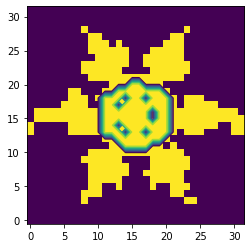

In [206]:
pp=nc.calc_psf(oversample=1, fov_pixels=32)[0].data
psfmask1000 = pp > 0.001*pp.max()
psfmask100 = pp > 0.01*pp.max()
psfmask5pct = pp > 0.05*pp.max()

pl.imshow(psfmask1000,)
pl.contour(psfmask100)

In [207]:
masked_data = data.copy()
for row in stars_deep_conv:
    xc,yc = row['xcentroid'], row['ycentroid']
    #mreg = regions.CirclePixelRegion(regions.PixCoord(xc, yc), radius=fwhm_pix*1.5)
    mreg = regions.RectanglePixelRegion(regions.PixCoord(xc, yc), width=31, height=31)

    msk = mreg.to_mask()
    slcs, sslcs = msk.get_overlap_slices(masked_data.shape)
    try:
        #masked_data[slcs][msk.data.astype('bool')] = np.nan
        masked_data[slcs][psfmask5pct.astype('bool')[sslcs]] = np.nan

    except IndexError:
        # border case
        pass
for row in stars_shallow_conv:
    xc,yc = row['xcentroid'], row['ycentroid']
    #mreg = regions.CirclePixelRegion(regions.PixCoord(xc, yc), radius=15)
    mreg = regions.RectanglePixelRegion(regions.PixCoord(xc, yc), width=31, height=31)
    msk = mreg.to_mask()
    slcs, sslcs = msk.get_overlap_slices(masked_data.shape)
    try:
        #masked_data[slcs][msk.data.astype('bool')] = np.nan
        masked_data[slcs][psfmask1000.astype('bool')[sslcs]] = np.nan
    except IndexError:
        # border case
        pass

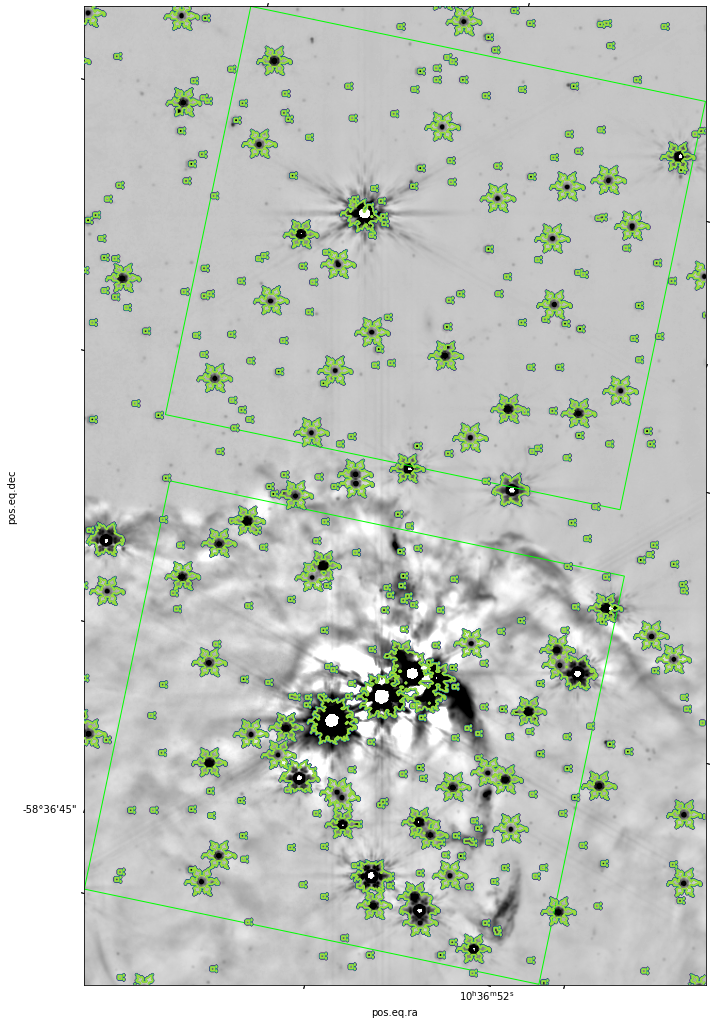

In [208]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(data)-mask.cutout(medfilt)
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)
ax.contour(np.isnan(masked_data[bigslc]))

#xx, yy = stars_deep['xcentroid'], stars_deep['ycentroid']
#sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
#                for xi, yi in zip(xx,yy)])
#ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', facecolor='none', edgecolor='lime')
#
#xx, yy = stars_shallow['xcentroid'], stars_shallow['ycentroid']
#sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
#                for xi, yi in zip(xx,yy)])
#ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', facecolor='none', edgecolor='red')

In [ ]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(masked_data)
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

In [ ]:
fwhm_pix

This isn't working so hot: there are clear artifacts in the resulting 'medfilt_masked' data set that come from interpolating into the holes.

For reasons I don't understand, they're asymmetric.

In [ ]:
#medfilt_masked = median_filter(masked_data, size=[9,9])
#conv = convolve(medfilt_masked, kernel=Gaussian2DKernel(fwhm_pix), nan_treatment='interpolate')
outname = 'F444W_convolution-based-background.fits'
if os.path.exists(outname):
    conv = fits.getdata(outname)
else:
    conv = convolve(masked_data, kernel=Gaussian2DKernel(fwhm_pix, x_size=np.ceil(10*fwhm_pix)), nan_treatment='interpolate')
    fits.PrimaryHDU(data=conv, header=im1[1].header).writeto(outname, overwrite=True)
    
medfilt_masked[np.isnan(medfilt_masked)] = conv[np.isnan(medfilt_masked)]
#medfilt_masked = median_filter(medfilt_masked, size=[9,9])

In [ ]:
fits.PrimaryHDU(data=medfilt_masked, header=im1[1].header).writeto('F444W_filter-based-background.fits', overwrite=True)

In [ ]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(np.nan_to_num(medfilt_masked))
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

In [ ]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(np.nan_to_num(conv))
bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

In [ ]:
data_replacenans = data.copy()
data_replacenans[filled_in_pixels] = datafilt_conv_psf[filled_in_pixels]
filtered_data = data_replacenans - medfilt_masked
filtered_data = data_replacenans - conv

In [ ]:
fits.PrimaryHDU(data=filtered_data, header=im1[1].header).writeto('F444W_filter-based-background-subtraction.fits', overwrite=True)

In [ ]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(filtered_data)
bigslc, smlslc = mask.bbox.get_overlap_slices(medfilt.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)
#ax.contour(np.isnan(masked_data[bigslc]))

#xx, yy = stars_deep['xcentroid'], stars_deep['ycentroid']
#sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
#                for xi, yi in zip(xx,yy)])
#ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', facecolor='none', edgecolor='lime')
#
#xx, yy = stars_shallow['xcentroid'], stars_shallow['ycentroid']
#sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
#                for xi, yi in zip(xx,yy)])
#ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', facecolor='none', edgecolor='red')

In [ ]:
data_cts = filtered_data / im1[1].header['PHOTMJSR']


bad_shallow = (np.abs(stars_shallow['roundness2']) > 0.25) | (np.abs(stars_shallow['roundness1']) > 0.25)


stars_tbl = Table()
stars_tbl['x'] = stars_shallow['xcentroid'][~bad_shallow]
stars_tbl['y'] = stars_shallow['ycentroid'][~bad_shallow]


nddata = NDData(data=filtered_data)
sz = 31
stars_ = extract_stars(nddata, stars_tbl, size=sz)

# Remove off-center stars
stars = photutils.psf.epsf_stars.EPSFStars([star for star in stars_
                                            if np.unravel_index(np.argmax(star), star.shape) == (sz//2, sz//2)
                                            and data[int(star.center[1]), int(star.center[0])] > 0 # don't want the ones we replaced
                                           ])

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10, progress_bar=True, smoothing_kernel='quadratic')

epsf_quadratic_filtered, fitted_stars = epsf_builder(stars)

In [ ]:
fits.PrimaryHDU(data=epsf_quadratic_filtered.data).write('F444W_ePSF_quadratic_filtered-background-subtracted.fits')

In [ ]:
nrows = 5
ncols = 5
fig, ax = pl.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i+75], 'log', percent=99.)
    ax[i].imshow(stars[i+75], norm=norm, origin='lower', cmap='viridis')

In [ ]:
ax = pl.gca()
norm_epsf = simple_norm(epsf_quadratic_filtered.data, 'log', percent=99.)
ax.set_title(f"{filt} quadratic", fontsize=20)
ax.imshow(epsf_quadratic_filtered.data, norm=norm_epsf)
ax.set_xlabel('X [px]', fontsize=20)
ax.set_ylabel('Y [px]', fontsize=20)

In [ ]:
yy,xx = np.indices(epsf_quadratic_filtered.data.shape)
xc,yc = np.unravel_index(epsf_quadratic_filtered.data.argmax(), epsf_quadratic_filtered.data.shape)
grid.x_0 = xc/oversample
grid.y_0 = yc/oversample
fitted_gridmod = fitter(model=grid, x=xx/oversample, y=yy/oversample, z=epsf_quadratic_filtered.data,)
gridmodpsf = (grid(xx/oversample, yy/oversample))
fitted_gridmod

In [ ]:
pl.figure(figsize=(16,5))
ax = pl.subplot(1,3,1)
norm_epsf = simple_norm(epsf_quadratic_filtered.data, 'log', percent=99.)
ax.set_title(f"{filt} quadratic\nfrom median-filtered data")
im = ax.imshow(epsf_quadratic_filtered.data, norm=norm_epsf)
pl.colorbar(mappable=im)
ax.set_xlabel('X [px]', fontsize=20)
ax.set_ylabel('Y [px]', fontsize=20)
ax2 = pl.subplot(1,3,2)
ax2.set_title("WebbPSF model")
dd = gridmodpsf    
norm = simple_norm(dd, 'log', percent=99.)
im2 = ax2.imshow(dd, norm=norm)       
pl.colorbar(mappable=im2)
ax3 = pl.subplot(1,3,3)
ax3.set_title("Difference")
#dd = (epsf_quadratic_medfilt.data/epsf_quadratic_medfilt.data.max()) - gridmodpsf/gridmodpsf.max()
dd = (epsf_quadratic_filtered.data) - gridmodpsf
norm = simple_norm(dd, 'asinh', percent=99)
im3 = ax3.imshow(dd, norm=norm)
pl.colorbar(mappable=im3)

## Do the PSF photometry

DAOGroup decides which subset of stars needs to be simultaneously fitted together - i.e., it deals with blended sources.



In [470]:
daogroup = DAOGroup(5 * fwhm_pix)
mmm_bkg = MMMBackground()

filtered_errest = stats.mad_std(filtered_data, ignore_nan=True)
print(filtered_errest)

daofind_fin = DAOStarFinder(threshold=10 * filtered_errest, fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)
finstars = daofind_fin(filtered_data)

# see plots below

def filtered_finder(data, *args, **kwargs):
    """
    Wrap the star finder to reject bad stars
    """
    finstars = daofind_fin(data)
    bad = ((finstars['roundness1'] > finstars['mag']*0.4/8+0.65) | (finstars['roundness1'] < finstars['mag']*-0.4/8-0.5) | 
           (finstars['sharpness'] < 0.48) | (finstars['sharpness'] > 0.6) | 
           (finstars['roundness2'] > finstars['mag']*0.4/8+0.55) | (finstars['roundness2'] < finstars['mag']*-0.4/8-0.5))
    finstars = finstars[~bad]
    finstars['id'] = np.arange(1, len(finstars)+1)
    print(f"Filtered {bad.sum()} bad stars out")
    assert 1 in finstars['id']
    assert len(finstars) in finstars['id']
    assert len(finstars)+1 not in finstars['id']
    return finstars

len(finstars), bad.sum()

0.04468374944770614


(41491, 13492)

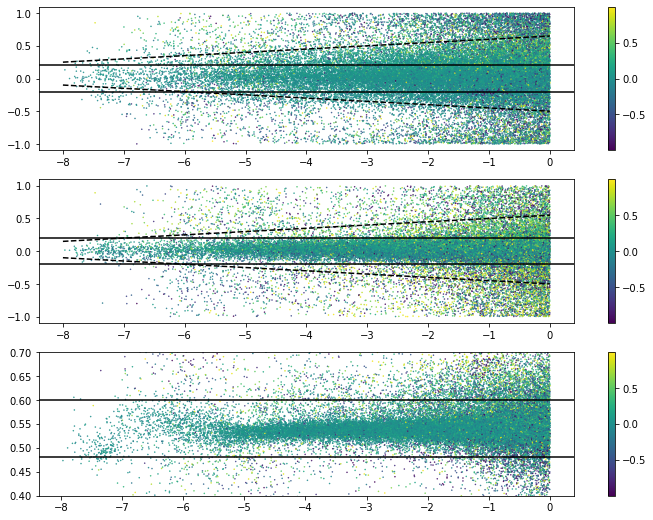

In [458]:
pl.figure(figsize=(12,9))
ax1 = pl.subplot(3,1,1)
sc1=ax1.scatter(finstars['mag'], finstars['roundness1'], c=finstars['roundness2'], marker='.', s=1)
ax1.axhline(-0.2, color='k')
ax1.axhline(0.2, color='k')
ax1.plot(np.linspace(-8,0), np.linspace(-8,0)*0.4/8 + 0.65, 'k--')
ax1.plot(np.linspace(-8,0), np.linspace(-8,0)*-0.4/8 - 0.5, 'k--')
pl.colorbar(mappable=sc1)
ax3 = pl.subplot(3,1,2)
sc3=ax3.scatter(finstars['mag'], finstars['roundness2'], c=finstars['roundness1'], marker='.', s=1)
ax3.axhline(-0.2, color='k')
ax3.axhline(0.2, color='k')
ax3.plot(np.linspace(-8,0), np.linspace(-8,0)*0.4/8 + 0.55, 'k--')
ax3.plot(np.linspace(-8,0), np.linspace(-8,0)*-0.4/8 - 0.5, 'k--')
pl.colorbar(mappable=sc3)
ax2 = pl.subplot(3,1,3)
sc2 = ax2.scatter(finstars['mag'], finstars['sharpness'], c=finstars['roundness2'], marker='.', s=1)
ax2.axhline(0.48, color='k')
ax2.axhline(0.6, color='k')
ax2.set_ylim(0.4, 0.7)
pl.colorbar(mappable=sc2)

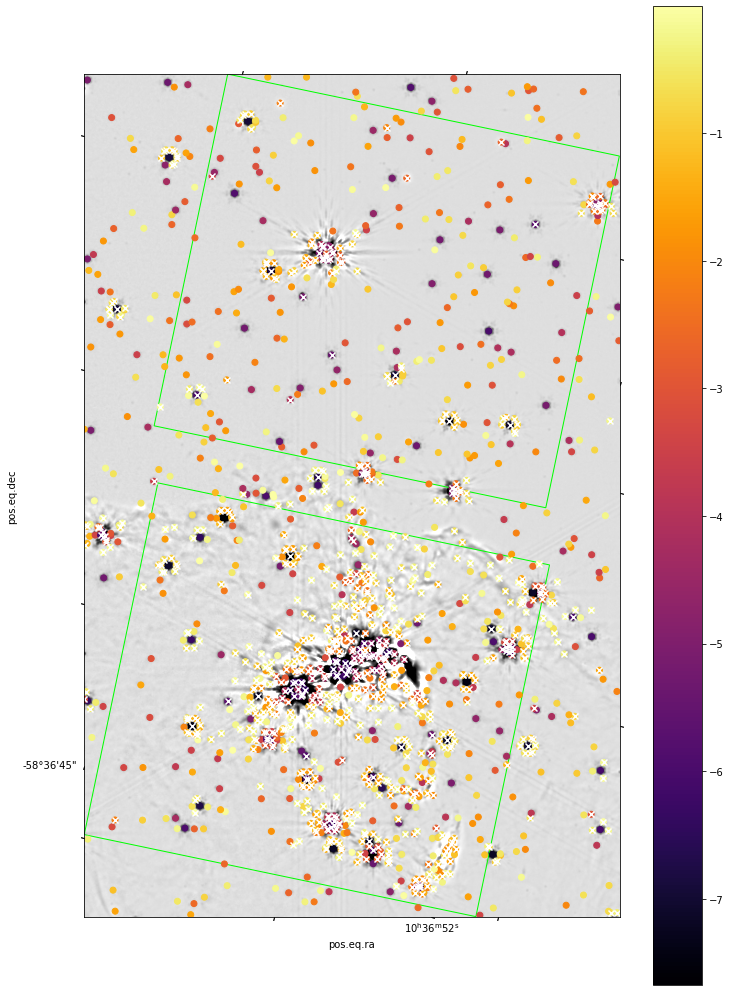

In [459]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(filtered_data)
bigslc, smlslc = mask.bbox.get_overlap_slices(filtered_data.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

xx, yy = finstars['xcentroid'], finstars['ycentroid']
sel = np.array([mask.bbox.to_region().contains(regions.PixCoord(xi, yi))
                for xi, yi in zip(xx,yy)])
mappable = ax.scatter(xx[sel]-mask.bbox.ixmin, yy[sel]-mask.bbox.iymin, marker='o', c=(finstars['mag'][sel]), cmap=pl.cm.inferno)
pl.colorbar(mappable=mappable)
bad = ((finstars['roundness1'] > finstars['mag']*0.4/8+0.65) | (finstars['roundness1'] < finstars['mag']*-0.4/8-0.5) | 
       (finstars['sharpness'] < 0.48) | (finstars['sharpness'] > 0.6) | 
       (finstars['roundness2'] > finstars['mag']*0.4/8+0.55) | (finstars['roundness2'] < finstars['mag']*-0.4/8-0.5))
ax.scatter(xx[bad & sel]-mask.bbox.ixmin, yy[bad & sel]-mask.bbox.iymin, marker='x', c='w')

In [474]:
phot = IterativelySubtractedPSFPhotometry(finder=filtered_finder, group_maker=daogroup,
                                          bkg_estimator=mmm_bkg,
                                          #psf_model=psf_modelgrid[0],
                                          psf_model=epsf_quadratic_filtered,
                                          fitter=LevMarLSQFitter(),
                                          niters=2, fitshape=(11, 11), aperture_radius=2*fwhm_pix)

First, experiment on a small subset

(I do not know how the WebbPSF grid interacts with this)

In [475]:
len(filtered_finder(mask.cutout(filtered_data)))

Filtered 772 bad stars out


643

In [476]:
mask.cutout(filtered_data).shape

(919, 584)

In [477]:
cdata = np.nan_to_num(mask.cutout(filtered_data))
result = phot(cdata)
resid = phot.get_residual_image()

Filtered 775 bad stars out


Filtered 941 bad stars out


Filtered 981 bad stars out


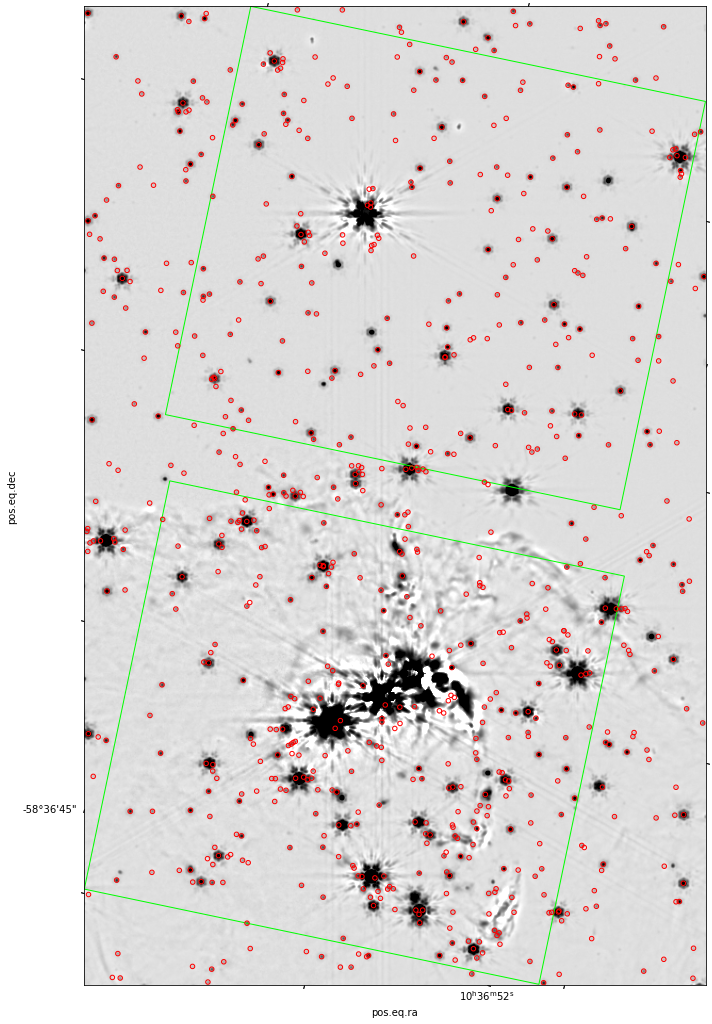

In [485]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = (np.nan_to_num(mask.cutout(filtered_data)))
bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)
ax.scatter(result['x_fit'], result['y_fit'], marker='o', s=20, facecolor='none', edgecolor='r')

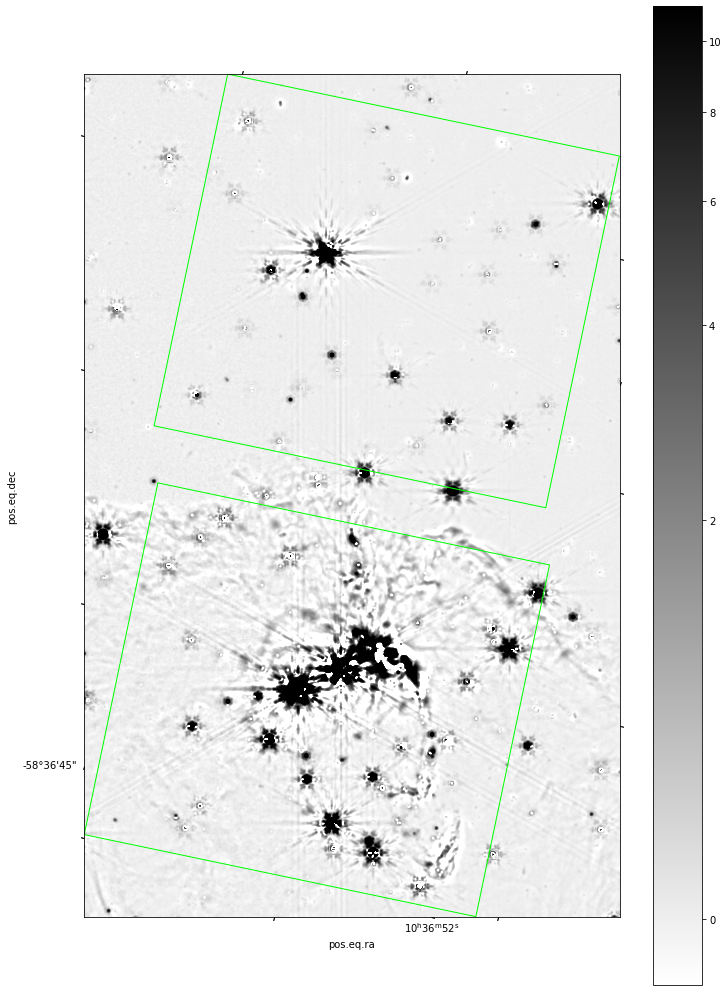

In [486]:
mask = (r0|r1).to_pixel(ww).to_mask()
resid = phot.get_residual_image()
mdata = (resid)
bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
im = ax.imshow(mdata, norm=simple_norm(mdata, min_percent=5, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)
pl.colorbar(mappable=im)

In [488]:
result.write('F444W_subframe_photometry.ecsv', overwrite=True)

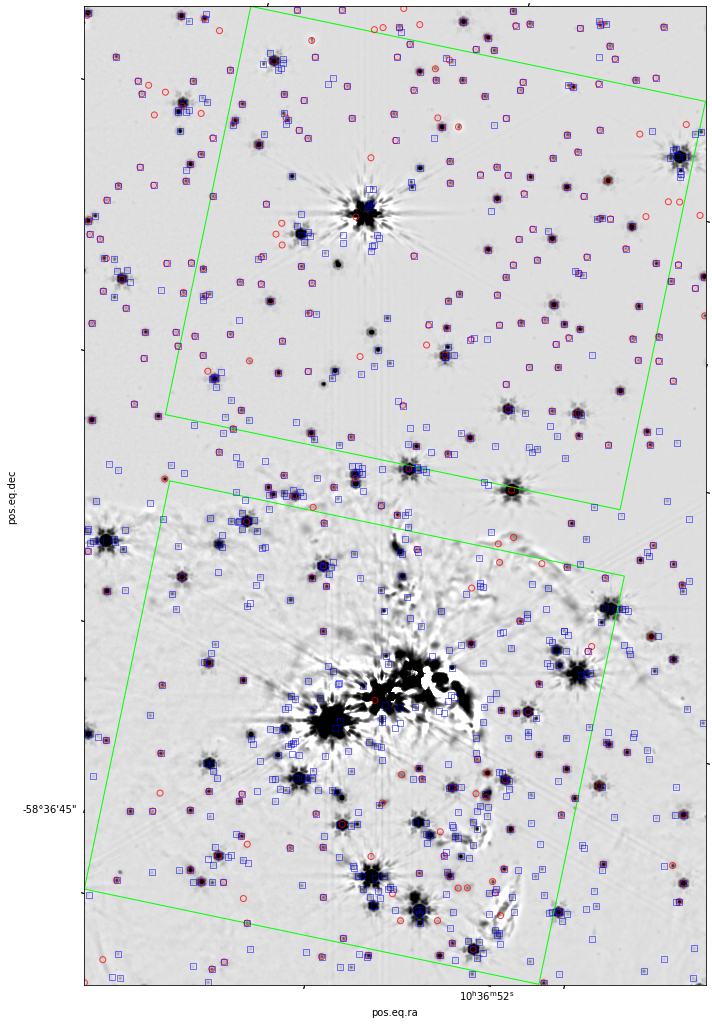

In [489]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = (np.nan_to_num(mask.cutout(filtered_data)))
bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

crds = basetable['sky_centroid']
sel = mask.bbox.to_region().to_sky(ww).contains(crds, wcs=ww)
ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), facecolor='none', edgecolor='r', alpha=0.75)

ax.scatter(result['x_fit'], result['y_fit'], marker='s', facecolor='none', edgecolor='b', alpha=0.50)

In [490]:
resid_orig = photutils.psf.utils.subtract_psf(mask.cutout(data), epsf_quadratic_filtered, result)

<WCSAxesSubplot:>

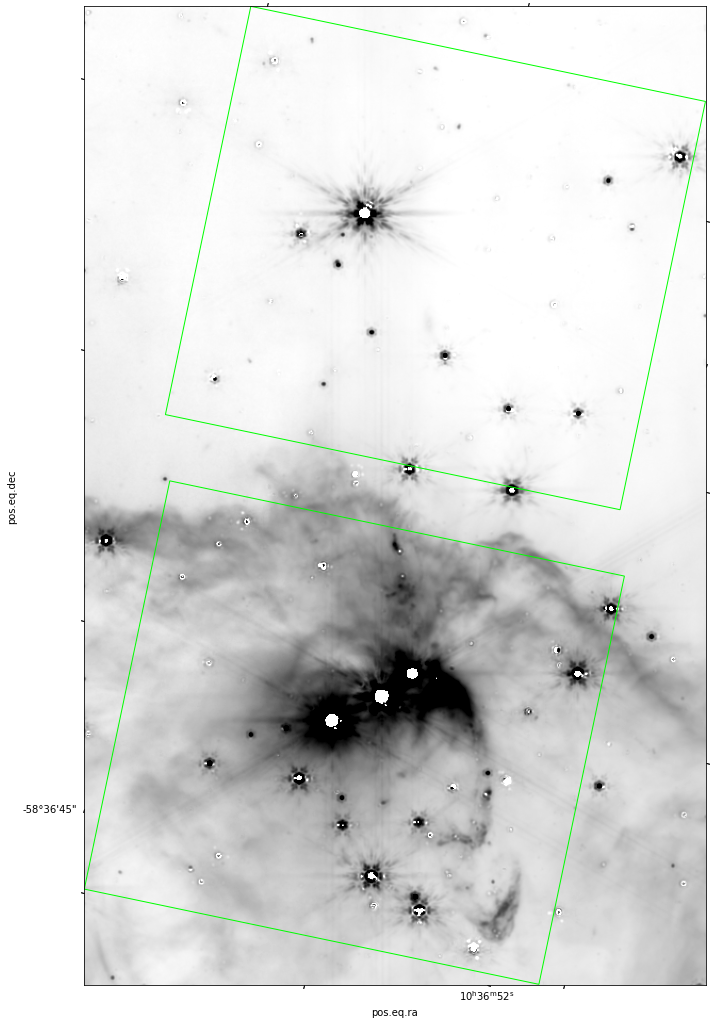

In [491]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = (resid_orig)
bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=5, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

In [ ]:
# operate on the full data
result_full = phot(np.nan_to_num(filtered_data))
result_full.write('F444W_fullfield_photometry.ecsv')
resid = phot.get_residual_image()
fits.PrimaryHDU(data=resid, header=im1[1].header).writeto('F444W_psfphot_residual.fits', overwrite=True)

Filtered 13549 bad stars out


In [ ]:
resid_orig = photutils.psf.utils.subtract_psf(data, epsf_quadratic_filtered, result_full)
fits.PrimaryHDU(data=resid, header=im1[1].header).writeto('F444W_psfphot_stars_removed.fits', overwrite=True)

<WCSAxesSubplot:>

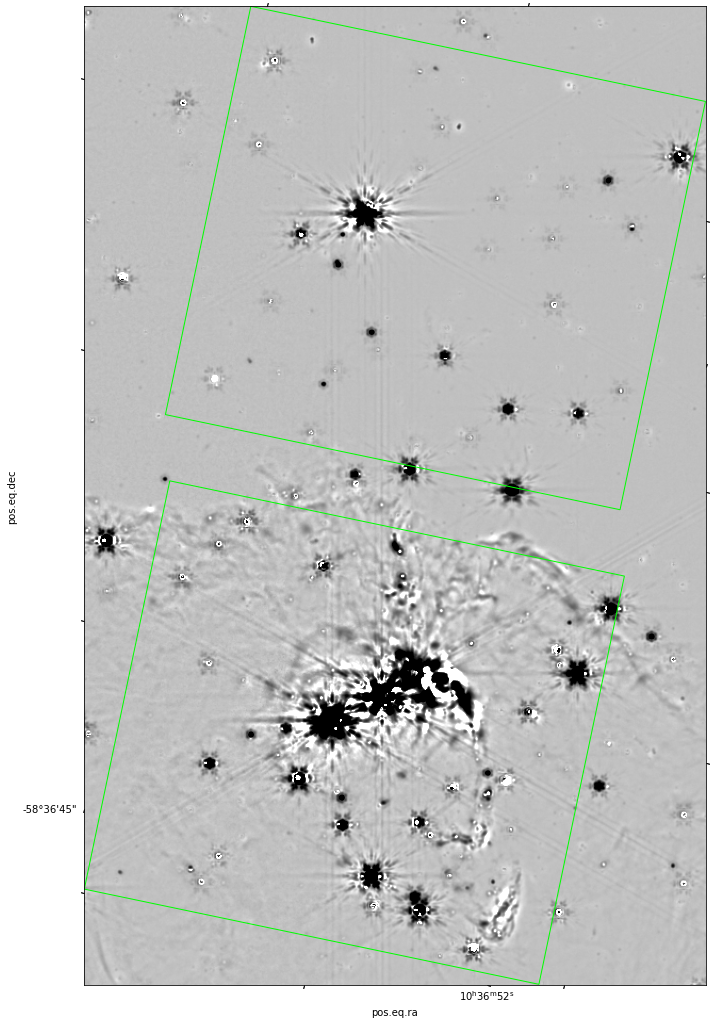

In [495]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(resid)
bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

In [ ]:
mask = (r0|r1).to_pixel(ww).to_mask()
mdata = mask.cutout(resid_orig)
bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)

pl.figure(figsize=(12,18))
ax = pl.subplot(projection=ww[bigslc])
ax.imshow(mdata, norm=simple_norm(mdata, min_percent=1, max_percent=99., stretch='asinh'), cmap='gray_r')
r0.to_pixel(ww[bigslc]).plot(ax=ax)
r1.to_pixel(ww[bigslc]).plot(ax=ax)

In [1]:
print("TEST")

TEST
